# Real Estate Investment

## Project Objectives

The CIO of your asset management company is interested in expanding the business and venturing into real estate flipping of undervalued houses in tier 3 cities. You are tasked with the job of building a model to predict the fair value of houses on the Ames, Iowa market and the type of renovations that would increase the value of the houses. Your CIO is interested in knowing whether this strategy will generate alpha (profit) and is worth pursuing. The metric you would use to evaluate the success of the project is the RMSE.

## Background

When analysing real estate data, features must be divided into two categories: universal features and location-specific features.

After speaking to real estate professionals, these features are deemed universal:
- Neighborhood desirability: the reputation of a neighborhood the house is located at.
- Age of the house - the era and decade it is constructed, and whether any significant historical events happen during that era (eg. the subprime mortgage crisis in 2008).
- Features relating to the size of the house, such as ground living area, total area, and number of bedrooms.
- Features relating to the quality of the house, especially the materials constructed and the foundation.

There are also features specific to American suburban cities:
- Kitchen quality: having a swanky kitchen is part of the American suburban dream. Americans celebrate traditions such as Thanksgiving with their friends and relatives; having a high quality kitchen allows one to be an excellent host.
- Basement quality/condition: this is applicable to older American houses, as newer apartments do not have a basement. A large basement is highly desirable

In [1]:
#imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

## Missing Data

This section deals with excluding 5 columns from the dataset due to excessive amount of null values and splitting columns into categorical vs numerical.

Note: when studying the dataset, the columns are categorized into ordinal, nominal, ratio and interval, but filtering columns into cat vs num is done for expediency.

In [2]:
#import data

train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [3]:
train.columns = train.columns.str.strip().str.lower()
train.columns = train.columns.str.replace(" ", "_")
test.columns = test.columns.str.strip().str.lower()
test.columns = test.columns.str.replace(" ", "_")

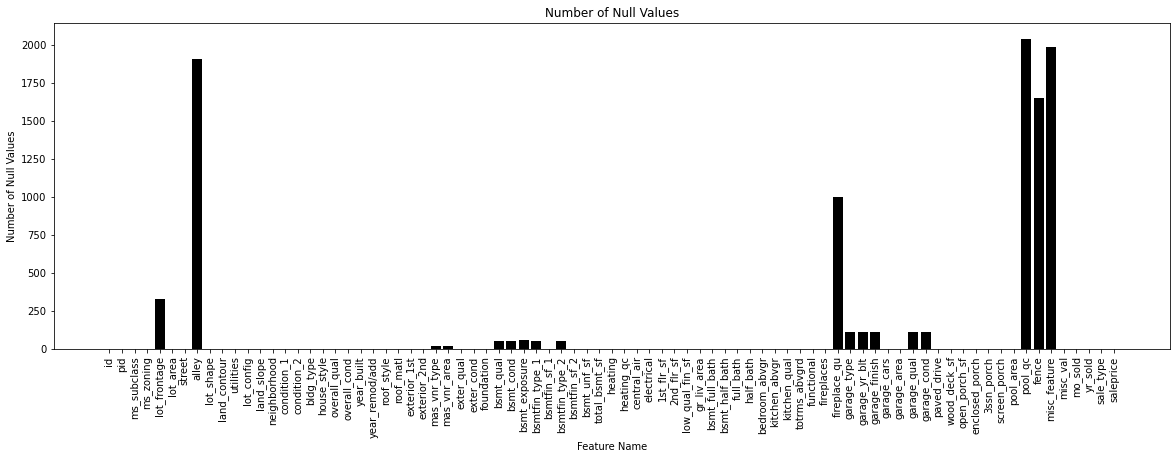

In [4]:
#plot barchart

plt.figure(figsize = (20, 6))
plt.bar(x = train.columns, height = train.isnull().sum(), color = "black")
plt.xlabel("Feature Name")
plt.xticks(rotation = 90)
plt.ylabel("Number of Null Values")
plt.title("Number of Null Values")
plt.show()

Features with high levels of missing data will be excluded from analysis:

- Pool QC: 99.5%
- MiscFeature: 96%
- Alley: 94%
- Fence: 81%

In [5]:
train.drop(columns= ["pool_qc", "misc_feature", "alley", "fence", "pid"], inplace = True)
test.drop(columns = ["pool_qc", "misc_feature", "alley", "fence", "pid"], inplace = True)
print(train.shape)

(2051, 76)


In [6]:
train.to_csv("datasets/train_cleaned.csv")
test.to_csv("datasets/test_cleaned.csv")

In [7]:
train_num = train.select_dtypes(include=[np.number])
train_cat = train.select_dtypes(exclude=[np.number])

test_num = test.select_dtypes(include=[np.number])
test_cat = test.select_dtypes(exclude=[np.number])

# Categorical Features Analysis

## Data Preparation: Encoding & Imputation

Statistical tests like Kruskal-Wallis require data to be in a specific format to work.

In [11]:
def rank_encoder(df, d, arr):
    for column in df.columns:
        if column in arr:
            df[column] = df[column].map(d)

In [12]:
quality = {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

ordinal_cols = ["exter_qual", "exter_cond", "kitchen_qual", "fireplace_qu", "garage_qual", "garage_cond", "bsmt_qual",
                "bsmt_cond", "heating_qc"]


rank_encoder(train_cat, quality, ordinal_cols)
rank_encoder(test_cat, quality, ordinal_cols)

#manually mapping the rest

train_cat["functional"] = train_cat["functional"].map({"Typ": 8, "Min1": 7, "Min2": 6, "Mod": 5, "Maj1": 4, "Maj2": 3, "Sev": 2, "Sal": 1})
test_cat["functional"] = test_cat["functional"].map({"Typ": 8, "Min1": 7, "Min2": 6, "Mod": 5, "Maj1": 4, "Maj2": 3, "Sev": 2, "Sal": 1})

train_cat["bsmt_exposure"] = train_cat["bsmt_exposure"].map({np.nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4})
test_cat["bsmt_exposure"] = test_cat["bsmt_exposure"].map({np.nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4})

### Imputation of Null Values - Ordinal

In [13]:
def imputer(df, cols):
    ordinal = df.filter(cols)
    imputer = KNNImputer(n_neighbors = 3)
    ordinal = pd.DataFrame(imputer.fit_transform(ordinal),columns = ordinal.columns)

    for col in cols:
        df[col] = ordinal[col]
        
    return df

In [14]:
train_cat = imputer(train_cat, ordinal_cols)
test_cat = imputer(test_cat, ordinal_cols)

# Kruskal-Wallis test

The Kruskal-Wallis test is the non-parametric version of the ANOVA test and is suitable for finding relationships between categorial features and a continuous feature (eg. sales price). The null hypothesis is that all the feature's categories have a similar median.

If there are statistically significant differences between intragroup medians of the feature's categories, the feature may have some predictive power towards sales price.

In [15]:
def kruskal_tester(df, target="saleprice"):
    
    kw = pd.DataFrame()
    p_values = []
    for col in df.columns:
        groups = train_cat[col].unique()
        train_temp = train_cat.copy()
        train_temp["saleprice"] = train["saleprice"]
        g_list = [train_temp[train_temp[col]==group][target].to_numpy() for group in groups]
        stats_return, p_value = stats.kruskal(*g_list)
        p_values.append(p_value)
    
    kw["Features"] = df.columns
    kw["P-values"] = p_values
    kw.dropna(inplace = True)
    
    return kw

In [16]:
ks = kruskal_tester(train_cat)
ks

,Features,P-values
0,ms_zoning,1.539369e-76
1,street,2.679931e-04
2,lot_shape,3.761101e-58
3,land_contour,3.032091e-16
4,utilities,1.915999e-01
5,lot_config,5.809141e-11
6,land_slope,4.829981e-02
7,neighborhood,3.102631e-249
8,condition_1,4.592461e-23
9,condition_2,2.633058e-05


According to the Kruskal-Wallis test, all of the columns except utilities have a p-value of less than 0.05, which means the difference between the medians of the categories are statistically significant and these variables are suitable predictors of sale price, the target variable.

## Final Steps - Merging & Saving

In [17]:
def merger(df, to_drop, to_dummify, to_merge, name):
    try:
        df.drop(to_drop, axis = 1, inplace = True)
    except KeyError:
        pass
    df_2 = pd.get_dummies(df, columns = to_dummify, drop_first = True)
    
    df_2["id"] = to_merge["id"]
    
    final = to_merge.merge(df_2, how = "outer", on = "id")
    final.to_csv(f"datasets/{name}.csv")
    return final

In [18]:
to_drop = ["utilities", "street", "ms_zoning"]
to_dummify = list(set(train_cat.columns) - set(ordinal_cols) - set(to_drop) - set(["bsmt_exposure", "functional"]))
to_dummify.remove("neighborhood")

In [19]:
train_final = merger(train_cat, to_drop, to_dummify, train_num, name = "train_cat_processed")
test_final = merger(test_cat, to_drop, to_dummify, test_num, name = "test_cat_processed")